# Importing libraries

In [111]:
import numpy as np
from scipy.signal import savgol_filter

from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torch.optim as optim

import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# width of the print
np.set_printoptions(linewidth=300)

## This is the code for the LSTM many to many with N Sequence to output

# Data generation

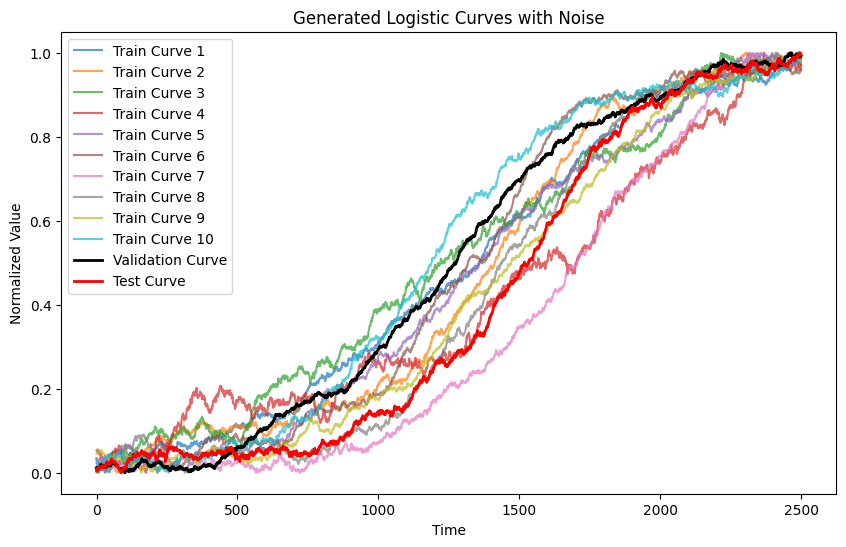

In [2]:

# Logistic function
def logistic_curve(x, L, k, x0, b):
    """Generate a logistic curve."""
    return L / (1 + np.exp(-k * (x - x0))) + b

# Add noise to data
def add_noise(data, noise_level=0.05):
    """Add random noise to the curve."""
    noise = np.random.normal(0, noise_level, len(data))
    cumulative_noise = np.cumsum(np.random.normal(0, 2.5, len(data)))
    return data + noise + cumulative_noise

# Generate curves
def generate_curves(num_curves, t, param_ranges, noise_level=0.05):
    """Generate multiple logistic curves with noise."""
    curves = []
    for _ in range(num_curves):
        L = np.random.uniform(*param_ranges['L'])
        k = np.random.uniform(*param_ranges['k'])
        x0 = np.random.uniform(*param_ranges['x0'])
        b = np.random.uniform(*param_ranges['b'])
        curve = logistic_curve(t, L, k, x0, b)
        curve = add_noise(curve, noise_level)
        curves.append(curve)
    return curves

# Time points
t = np.linspace(0, 2500, 2500)

# Parameter ranges for generating curves
param_ranges = {
    "L": [900, 1300],   # Curve amplitude
    "k": [0.002, 0.006], # Growth rate
    "x0": [1200, 1700], # Midpoint
    "b": [0.01, 0.1]    # Vertical offset
}

# Generate 10 training curves, 1 validation curve, 1 test curve
train_curves = generate_curves(10, t, param_ranges, noise_level=1)
val_curve = generate_curves(1, t, param_ranges, noise_level=1)[0]
test_curve = generate_curves(1, t, param_ranges, noise_level=1)[0]

# Normalize curves
scaler = MinMaxScaler()
train_curves_scaled = [scaler.fit_transform(curve.reshape(-1, 1)).flatten() for curve in train_curves]
val_curve_scaled = scaler.fit_transform(val_curve.reshape(-1, 1)).flatten()
test_curve_scaled = scaler.fit_transform(test_curve.reshape(-1, 1)).flatten()

# Plot the curves for visualization
plt.figure(figsize=(10, 6))
for i, curve in enumerate(train_curves_scaled):
    plt.plot(t, curve, label=f"Train Curve {i+1}", alpha=0.7)
plt.plot(t, val_curve_scaled, label="Validation Curve", color="black", linewidth=2)
plt.plot(t, test_curve_scaled, label="Test Curve", color="red", linewidth=2)
plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.title("Generated Logistic Curves with Noise")
plt.legend()
plt.show()


# Data preparation pytorch *Dataset* and *DataLoader*

In [3]:
class TimeSeriesManyToManyDatasetOffsetOne(Dataset):
    def __init__(self, curves, seq_len):
        """
        Parameters:
        - curves: List of 1D numpy arrays (separate time series data).
        - seq_len: Length of input and target sequences.
        """
        self.curves = [torch.tensor(curve, dtype=torch.float32) for curve in curves]
        self.seq_len = seq_len

        # Precompute lengths to handle indexing across multiple curves
        self.cumulative_lengths = np.cumsum([max(0, len(curve) - seq_len) for curve in self.curves])

    def __len__(self):
        return self.cumulative_lengths[-1]

    def __getitem__(self, idx):
        """
        Maps a global index to the correct curve and returns:
        - x: Input sequence (seq_len).
        - y: Target sequence (seq_len).
        """
        # Find which curve this index belongs to
        curve_idx = np.searchsorted(self.cumulative_lengths, idx, side="right")
        curve_start_idx = 0 if curve_idx == 0 else self.cumulative_lengths[curve_idx - 1]
        local_idx = idx - curve_start_idx

        # Extract the corresponding sequence
        curve = self.curves[curve_idx]
        x = curve[local_idx : local_idx + self.seq_len]
        y = curve[local_idx + 1 : local_idx + self.seq_len + 1]
        return x.unsqueeze(-1), y.unsqueeze(-1)  # Add feature dimension for LSTM
    
class TimeSeriesManyToManySequenceDataset(Dataset):
    def __init__(self, curves, seq_len):
        self.curves = [torch.tensor(curve, dtype=torch.float32) for curve in curves]
        self.seq_len = seq_len
        self.cumulative_lengths = np.cumsum([max(0, len(curve) - 2 * seq_len) for curve in self.curves])

    def __len__(self):
        return self.cumulative_lengths[-1]

    def __getitem__(self, idx):
        curve_idx = np.searchsorted(self.cumulative_lengths, idx, side="right")
        curve_start_idx = 0 if curve_idx == 0 else self.cumulative_lengths[curve_idx - 1]
        local_idx = idx - curve_start_idx

        curve = self.curves[curve_idx]
        x = curve[local_idx : local_idx + self.seq_len]  # Input sequence
        y = curve[local_idx + self.seq_len : local_idx + 2 * self.seq_len]  # Target sequence (next window)
        return x.unsqueeze(-1), y.unsqueeze(-1)  # Add feature dimension



In [59]:
# Sequence length for input/output
sequence_length = 250

# Create datasets for training, validation, and testing
train_dataset = TimeSeriesManyToManySequenceDataset(train_curves_scaled, seq_len=sequence_length)
val_dataset = TimeSeriesManyToManySequenceDataset([val_curve_scaled], seq_len=sequence_length)
test_dataset = TimeSeriesManyToManySequenceDataset([test_curve_scaled], seq_len=sequence_length)


# DataLoader parameters
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check dataset lengths
print(f"Training Dataset: {len(train_dataset)} samples")
print(f"Validation Dataset: {len(val_dataset)} samples")
print(f"Test Dataset: {len(test_dataset)} samples")

Training Dataset: 20000 samples
Validation Dataset: 2000 samples
Test Dataset: 2000 samples


# Model definition

In [60]:
class ManyToManyLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(ManyToManyLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, dropout=0.3, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # LSTM output: (batch_size, seq_len, hidden_dim)
        output = self.fc(lstm_out)  # Linear layer applied at each time step
        return output


In [61]:
# Hyperparameters
input_dim = 1
hidden_dim = 50
output_dim = 1
num_layers = 1
learning_rate = 0.001


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ManyToManyLSTM(input_dim, hidden_dim, output_dim, num_layers).to(device)
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

m:\ML\lstm\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


# Training loop with validation

In [ ]:

num_epochs = 60
# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    train_loss = 0.0

    for x_batch_train, y_batch_train in tqdm(train_loader, desc=f"T Eph {epoch+1}/{num_epochs}"):
        # torch.Size([32, 50, 1])
        x_batch_train, y_batch_train = x_batch_train.to(device), y_batch_train.to(device)
        optimizer.zero_grad()
        predictions = model(x_batch_train)
        loss = criterion(predictions, y_batch_train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_predictions = []
    with torch.no_grad():
        for x_batch_val, y_batch_val in tqdm(val_loader, desc=f"V Eph {epoch+1}/{num_epochs}"):
            x_batch_val, y_batch_val = x_batch_val.to(device), y_batch_val.to(device)
            v_predictions = model(x_batch_val)
            val_predictions.extend(v_predictions.cpu().numpy())
            loss = criterion(v_predictions, y_batch_val)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    # Print training and validation loss
    print(f"Epoch {epoch+1}/{num_epochs}, T Loss: {train_loss:.12f}, V Loss: {val_loss:.12f}")


# Test loop


In [63]:
def get_sequence_from_curve(curve, start_idx, seq_len):
    """
    Extract a sequence of a specified length from the curve starting at a given index.

    Parameters:
    - curve: The complete time series (1D numpy array or list).
    - start_idx: The starting index for the sequence.
    - seq_len: The length of the sequence to extract.

    Returns:
    - The extracted sequence as a numpy array.
    """
    end_idx = start_idx + seq_len
    if end_idx > len(curve):
        raise ValueError(f"End index {end_idx} exceeds curve length {len(curve)}.")
    return curve[start_idx:end_idx]


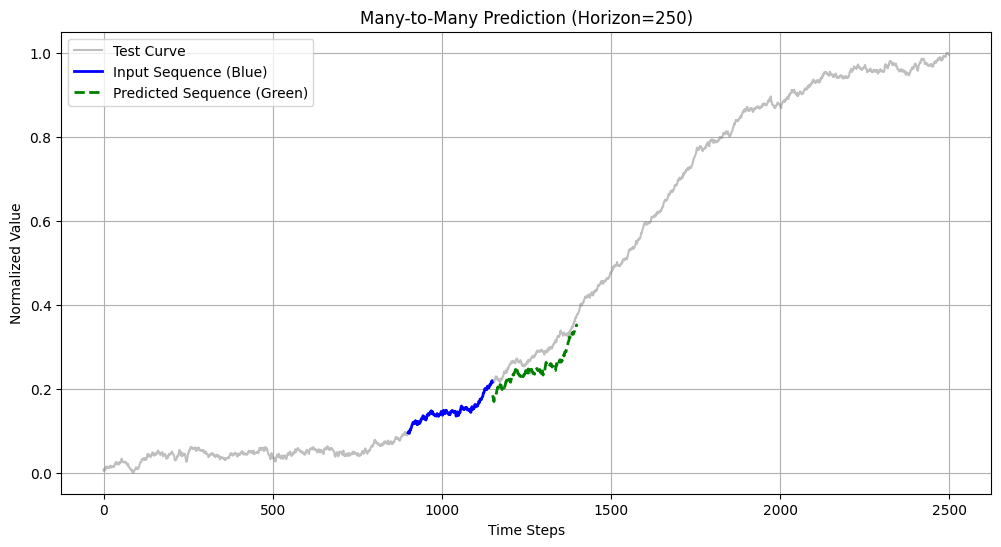

In [92]:

# Horizon prediction using Many-to-Many model
horizon = 250  # Length of the horizon to predict
start_idx = 900  # Start index for the input sequence
seq_len = 250  # Length of the input sequence

# Get input sequence
x_input = get_sequence_from_curve(test_curve_scaled, start_idx, seq_len)
x_input_tensor = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)

# Predict the horizon
model.eval()
with torch.no_grad():
    predictions = model(x_input_tensor).squeeze().cpu().numpy()  # Predict the next sequence

# Visualization
prediction_indices = np.arange(start_idx + seq_len, start_idx + seq_len + horizon)
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(test_curve_scaled)), test_curve_scaled, label="Test Curve", color="gray", alpha=0.5)
plt.plot(np.arange(start_idx, start_idx + seq_len), x_input, label="Input Sequence (Blue)", color="blue", linewidth=2)
plt.plot(prediction_indices[:len(predictions)], predictions, label="Predicted Sequence (Green)", color="green", linestyle="--", linewidth=2)
plt.title(f"Many-to-Many Prediction (Horizon={horizon})")
plt.xlabel("Time Steps")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.show()


torch.Size([1, 250, 1])
(2000,)


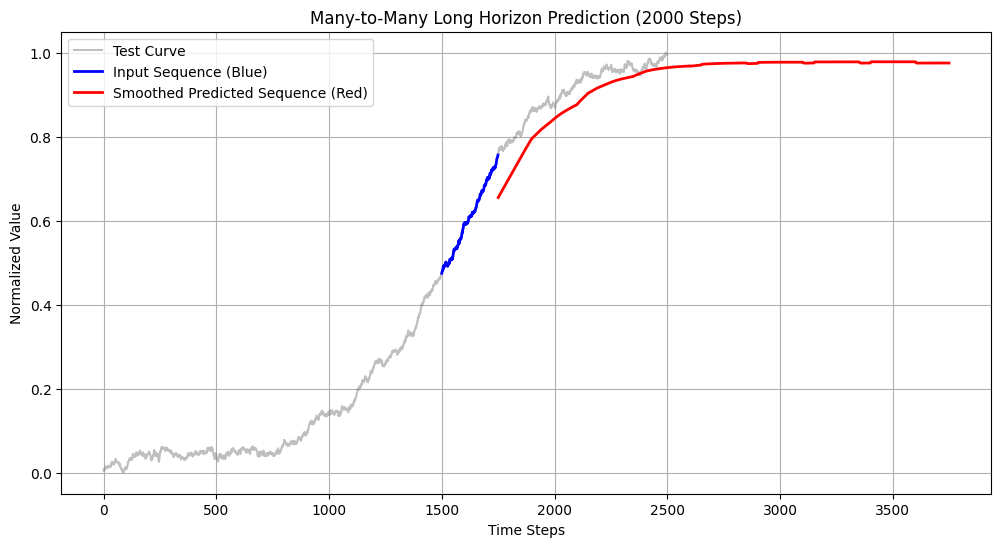

In [140]:
# Long horizon prediction using Many-to-Many model
long_horizon = 2000  # Number of steps to predict
start_idx = 1500  # Start index for the input sequence
seq_len = 250  # Length of the input sequence

# Get input sequence
x_input = get_sequence_from_curve(test_curve_scaled, start_idx, seq_len)
x_input_tensor = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)  # [1, seq_len, 1]
print(x_input_tensor.shape)
# Initialize list to store all predictions
all_predictions = []

# Auto-regressive prediction loop
model.eval()
with torch.no_grad():
    for _ in range(long_horizon // seq_len):
        # Predict the next sequence
        predictions = model(x_input_tensor).squeeze(0).cpu().numpy()  # Output shape: [seq_len, input_dim]
        all_predictions.append(predictions)

        # Use the predicted sequence as the next input
        x_input_tensor = torch.tensor(predictions, dtype=torch.float32).unsqueeze(0).to(device)

# Combine all predictions into a single array
all_predictions = np.concatenate(all_predictions, axis=0)

# Visualization
prediction_indices = np.arange(start_idx + seq_len, start_idx + seq_len + len(all_predictions))


# For smooth 
all_predictions = np.array(all_predictions).flatten()
print(all_predictions.shape)
smoothed_predictions = savgol_filter(all_predictions[:long_horizon], window_length=201, polyorder=1)

# Apply moving average to the predicted sequence
# smoothed_predictions = savgol_filter(all_predictions, window_size=50, poly_order=2)

plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(test_curve_scaled)), test_curve_scaled, label="Test Curve", color="gray", alpha=0.5)
plt.plot(np.arange(start_idx, start_idx + seq_len), x_input, label="Input Sequence (Blue)", color="blue", linewidth=2)
# plt.plot(prediction_indices, all_predictions[:long_horizon], label="Predicted Sequence (Green)", color="green", linestyle="--", linewidth=2)
plt.plot(prediction_indices, smoothed_predictions, label="Smoothed Predicted Sequence (Red)", color="red", linewidth=2)

plt.title(f"Many-to-Many Long Horizon Prediction ({long_horizon} Steps)")
plt.xlabel("Time Steps")
plt.ylabel("Normalized Value")
plt.legend()
plt.grid(True)
plt.show()
